<a href="https://colab.research.google.com/github/otitamario/sp-pa-gep/blob/main/epxp5_gep_matrizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the repository into Colab runtime
!git clone https://github.com/otitamario/sp-pa-gep.git

# Move into repo root
%cd sp-pa-gep

# Make sure Python sees the project root
import sys
sys.path.append(".")

Cloning into 'sp-pa-gep'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 103 (delta 38), reused 42 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (103/103), 1.17 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/sp-pa-gep


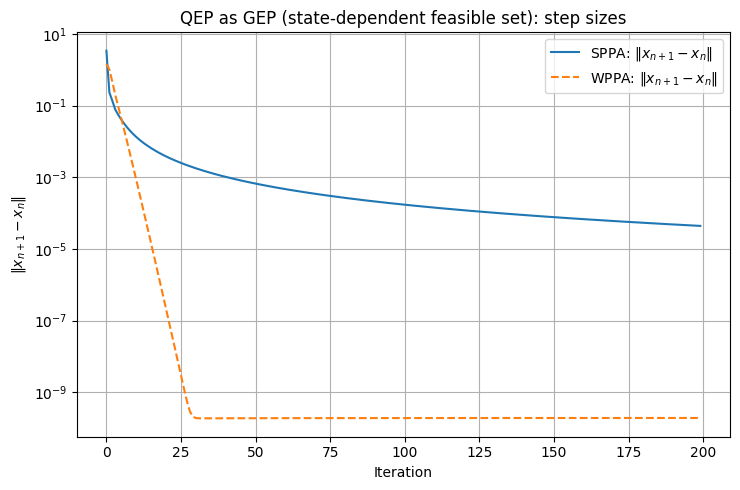

SPPA final x: [0.         0.99502488 0.66113875 0.         0.00464346]
WPPA final x: [0.         1.         0.66666667 0.         0.49999997]
SPPA iters: 200  | final step: 4.383811863242846e-05
WPPA iters: 200  | final step: 1.9046753063634014e-10


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Problem data (from the draft)
# -----------------------------
q = np.array([1, -2, -1, 2, -1], dtype=float)

P = np.array([
    [3.1, 2.0, 0,   0,   0],
    [2.0, 3.6, 0,   0,   0],
    [0,   0,   3.5, 2.0, 0],
    [0,   0,   2.0, 3.3, 0],
    [0,   0,   0,   0,   3.0],
], dtype=float)

Q = np.array([
    [1.6, 1.0, 0,   0,   0],
    [1.0, 1.6, 0,   0,   0],
    [0,   0,   1.5, 1.0, 0],
    [0,   0,   1.0, 1.5, 0],
    [0,   0,   0,   0,   2.0],
], dtype=float)

n = 5

# -----------------------------
# Sets K and C(x)
# -----------------------------
def proj_box(x, lo, hi):
    return np.minimum(np.maximum(x, lo), hi)

def C_upper(x):
    """Return the upper bound 'a(x)' so that C(x) = [0, a(x)]^5, with cap <= 2."""
    s = float(np.sum(x))
    if s <= 5.0:
        a = 1.0
    else:
        a = (s + 5.0) / 10.0
    # Ensure C(x) subset of K=[0,2]^5
    return min(a, 2.0)

def proj_C_of(x, y):
    """Project y onto C(x) = [0, a(x)]^5."""
    a = C_upper(x)
    return proj_box(y, 0.0, a)

def proj_K(y):
    return proj_box(y, 0.0, 2.0)

# -----------------------------
# Inner solver for resolvent (approx)
# -----------------------------
def solve_inner_qp_on_box(u_ref, x_n, r, y0=None, inner_it=300, inner_tol=1e-10):
    """
    Approximately solve a strongly convex quadratic over C(u_ref) using projected gradient:

        minimize_y  0.5 y^T (Q + (1/r) I) y + (P u_ref + q - (1/r) x_n)^T y
        subject to  y in C(u_ref) = [0, a(u_ref)]^5.

    This is a practical surrogate for the regularized EP step when C depends on u.
    """
    A = Q + (1.0 / r) * np.eye(n)
    b = P @ u_ref + q - (1.0 / r) * x_n

    # Lipschitz constant for grad: L = lambda_max(A)
    L = np.linalg.eigvalsh(A).max()
    step = 1.0 / L

    if y0 is None:
        y = proj_C_of(u_ref, x_n.copy())
    else:
        y = proj_C_of(u_ref, y0.copy())

    for _ in range(inner_it):
        grad = A @ y + b
        y_new = proj_C_of(u_ref, y - step * grad)
        if np.linalg.norm(y_new - y) <= inner_tol:
            y = y_new
            break
        y = y_new

    return y

def resolvent_state_dependent(x_n, r=1.0, fp_it=50, fp_tol=1e-10, inner_it=300):
    """
    Fixed-point loop for the state-dependent resolvent:
      u in C(u), and u approximates the regularized equilibrium step.

    We iterate:
      u^{j+1} = argmin over C(u^j) of a convex QP (solved approximately).
    """
    # Start in K
    u = proj_K(x_n.copy())

    for _ in range(fp_it):
        u_next = solve_inner_qp_on_box(u_ref=u, x_n=x_n, r=r, y0=u, inner_it=inner_it)
        u_next = proj_K(u_next)  # safety (should already lie in [0,2]^5)
        if np.linalg.norm(u_next - u) <= fp_tol:
            u = u_next
            break
        u = u_next

    return u

# -----------------------------
# SPPA / WPPA outer iterations
# -----------------------------
def run_sppa_wppa_qep_as_gep(
    x0,
    u_anchor=None,
    r=1.0,
    maxit=200,
    tol=1e-6,
    fp_it=50,
    inner_it=300,
):
    x0 = proj_K(np.array(x0, dtype=float))
    if u_anchor is None:
        u_anchor = np.zeros_like(x0)
    u_anchor = proj_K(np.array(u_anchor, dtype=float))

    xs_sppa = [x0.copy()]
    xs_wppa = [x0.copy()]
    step_sppa = []
    step_wppa = []

    x_sppa = x0.copy()
    x_wppa = x0.copy()

    for k in range(maxit):
        alpha = 1.0 / (k + 2)  # alpha_k = 1/(k+2)

        # --- SPPA ---
        u_n_sppa = resolvent_state_dependent(x_sppa, r=r, fp_it=fp_it, inner_it=inner_it)
        x_next_sppa = alpha * u_anchor + (1 - alpha) * u_n_sppa
        x_next_sppa = proj_K(x_next_sppa)

        step_sppa.append(np.linalg.norm(x_next_sppa - x_sppa))
        xs_sppa.append(x_next_sppa.copy())
        x_sppa = x_next_sppa

        # --- WPPA ---
        u_n_wppa = resolvent_state_dependent(x_wppa, r=r, fp_it=fp_it, inner_it=inner_it)
        x_next_wppa = alpha * x_wppa + (1 - alpha) * u_n_wppa
        x_next_wppa = proj_K(x_next_wppa)

        step_wppa.append(np.linalg.norm(x_next_wppa - x_wppa))
        xs_wppa.append(x_next_wppa.copy())
        x_wppa = x_next_wppa

        # stopping rule based on step size
        if step_sppa[-1] <= tol and step_wppa[-1] <= tol:
            break

    return np.array(xs_sppa), np.array(xs_wppa), np.array(step_sppa), np.array(step_wppa)

# -----------------------------
# Run + plot
# -----------------------------
x0 = np.ones(n) * 1.8  # any point in [0,2]^5
u_anchor = np.zeros(n) # Halpern anchor

xs_sppa, xs_wppa, step_sppa, step_wppa = run_sppa_wppa_qep_as_gep(
    x0=x0,
    u_anchor=u_anchor,
    r=1.0,
    maxit=200,
    tol=1e-6,
    fp_it=60,
    inner_it=400,
)

plt.figure(figsize=(7.5, 5))
plt.semilogy(step_sppa, label=r"SPPA: $\|x_{n+1}-x_n\|$")
plt.semilogy(step_wppa, linestyle="--", label=r"WPPA: $\|x_{n+1}-x_n\|$")
plt.xlabel("Iteration")
plt.ylabel(r"$\|x_{n+1}-x_n\|$")
plt.title("QEP as GEP (state-dependent feasible set): step sizes")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save BEFORE show (important in Colab)
plt.savefig("figures/exp_new_qep_gep_steps.png", dpi=300, bbox_inches="tight")
plt.show()

print("SPPA final x:", xs_sppa[-1])
print("WPPA final x:", xs_wppa[-1])
print("SPPA iters:", len(step_sppa), " | final step:", step_sppa[-1])
print("WPPA iters:", len(step_wppa), " | final step:", step_wppa[-1])

In [3]:
# ─── 1. Configurar seu nome e email (só precisa rodar uma vez)
!git config --global user.name "otitamario"
!git config --global user.email "mario2013sj@gmail.com"

In [6]:
# ─── 2. Método mais seguro e prático (usando cache de credencial) ────────────────

from google.colab import userdata

# Salve o token como segredo no Colab (muito recomendado!)
# Vá na barra lateral esquerda → chave de cadeado "Secrets"
# Adicione um segredo chamado: GITHUB_TOKEN
# Cole seu token lá e marque "Notebook access"

token = userdata.get('GITHUB_TOKEN')          # pega o segredo
username = "otitamario"               # seu username
repo = "sp-pa-gep"              # ex: meu-projeto

# Configura o remote com o token (https)
!git remote set-url origin https://{token}@github.com/{username}/{repo}.git

# Ou se ainda não tem remote configurado:
#!git remote add origin https://{token}@github.com/{username}/{repo}.git

In [7]:
# ─── 3. Verificar status e fazer push ───────────────────────────────────────────

!git status               # veja o que está acontecendo
!git add .                # adiciona tudo (ou escolha arquivos específicos)
!git commit -m "commit do colab: Exp5  gep matrizes"
!git push origin main     # ou master, ou a branch que você usa

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	figures/exp_new_qep_gep_steps.png

nothing added to commit but untracked files present (use "git add" to track)
[main dcffe19] commit do colab: Exp5  gep matrizes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 figures/exp_new_qep_gep_steps.png
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 97.71 KiB | 12.21 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/otitamario/sp-pa-gep.git
   37060c1..dcffe19  main -> main
